In [1]:
# 1. traditional backwards feature selection: take a feature out, retrain model without feature and see how performance changed. features who droppage least affects the
# model performance have love impact on predictive performance and should be permanently dropped
# 2. sensitivity analysis +backwards elimination feature selection. measuring how variance in each feature affects the output. THis method has different variants depending on the exact model
# (look into partial dependence plots)

In [2]:
%pip install ucimlrepo

###Loading the data set

In [3]:
from ucimlrepo import fetch_ucirepo
from ucimlrepo import list_available_datasets


# fetch dataset
wine_quality = fetch_ucirepo(id=186)


# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets



#X.head()
#y.head()
# variable information
#print(wine_quality.variables)

###Data Preprocessing: want to understand how the data is distributed and perfoming cleaning if necesary

<Axes: xlabel='quality'>

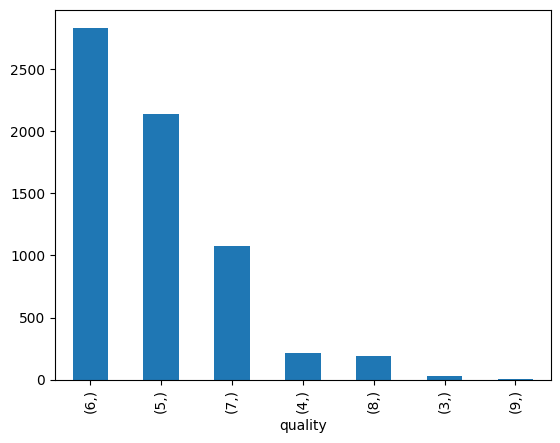

In [4]:
# histogram to give an idea of how imbalanced the quality is
#from matplotlib import pyplot as plt
#import seaborn as sns

y.value_counts().plot(kind='bar')

In [5]:
#X.describe()

#Model A (without sampling)



In [6]:
!pip install imbalanced-learn

###Split the data

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

y_flat = y.values.ravel()
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

###Check for imbalance in the training split

<Axes: xlabel='0'>

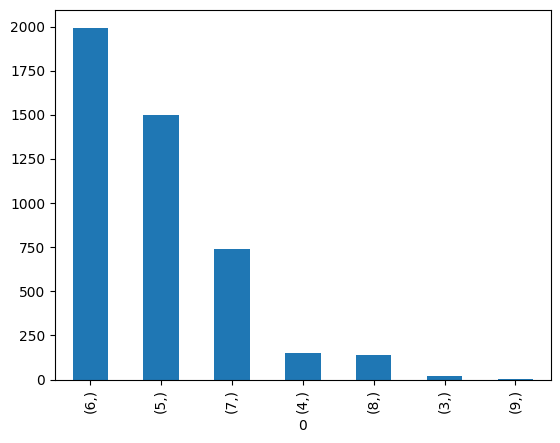

In [8]:
(pd.DataFrame(y_train)).value_counts().plot(kind='bar')

###I think its natural to have more normal wines that excellent ones so I would model with and without imbalance handling

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

best_models = []
KNN_results= []

k_values = [15,16,17,18,19,20,29,99,201]

for k in k_values:
  #define models
  uniform_KNN = KNeighborsClassifier(n_neighbors=k, weights='uniform')
  distance_KNN = KNeighborsClassifier(n_neighbors=k,weights='distance')

  #train models
  uniform_KNN.fit(X_train, y_train)
  distance_KNN.fit(X_train,y_train)

  #print (f'uniform params\n {uniform_KNN.get_params(deep=True)} \n\n')
  #print (f'distance params\n {distance_KNN.get_params(deep=True)} \n\n')

  # make predictions
  uniform_y_val_pred = uniform_KNN.predict(X_val)
  distance_y_val_pred = distance_KNN.predict(X_val)

  # compute metrics for uniform_KNN model
  uniform_accuracy = accuracy_score(y_val, uniform_y_val_pred)
  uniform_precision = precision_score(y_val, uniform_y_val_pred, average='macro',zero_division=np.nan)
  uniform_recall = recall_score(y_val, uniform_y_val_pred, average='macro')
  uniform_f1 = f1_score(y_val, uniform_y_val_pred, average='macro')

  # compute metrics for distance_KNN model
  distance_accuracy = accuracy_score(y_val, distance_y_val_pred)
  distance_precision = precision_score(y_val, distance_y_val_pred, average='macro',zero_division=np.nan)
  distance_recall = recall_score(y_val, distance_y_val_pred, average='macro')
  distance_f1 = f1_score(y_val, distance_y_val_pred, average='macro')


  # store BOTH results
  KNN_results.append({
      'Type': 'Non_FS',
      'accuracy' : uniform_accuracy,
      'precision' : uniform_precision,
      'recall' : uniform_recall,
      'f1' : uniform_f1,
      'n_neighbors': k,
      'weights': 'uniform',

  })

  KNN_results.append({
      'Type': 'Non_FS',
      'accuracy' : distance_accuracy,
      'precision' : distance_precision,
      'recall' : distance_recall,
      'f1' : distance_f1,
      'n_neighbors': k,
      'weights': 'distance',

  })

KNN_result_df = pd.DataFrame(KNN_results)

# sort by MSE
KNN_result_df.sort_values(by = 'accuracy', ascending= False, inplace=True)
KNN_result_df.reset_index(drop=True, inplace=True)

# I inspected the result dataframe and found that the first value was the best
best_KNN = KNN_result_df.iloc[0].to_dict()
best_models.append(best_KNN)#add the best model to the list

print(f'Best KNN Model {best_KNN}')

KNN_result_df.head()


Best KNN Model {'Type': 'Non_FS', 'accuracy': 0.6543589743589744, 'precision': 0.7761437627364538, 'recall': 0.32546999347947414, 'f1': 0.3477260774882584, 'n_neighbors': 29, 'weights': 'distance'}


,Type,accuracy,precision,recall,f1,n_neighbors,weights
0,Non_FS,0.654359,0.776144,0.325470,0.347726,29,distance
1,Non_FS,0.647179,0.764560,0.318053,0.337734,17,distance
2,Non_FS,0.646154,0.764422,0.323234,0.343444,20,distance
3,Non_FS,0.646154,0.761163,0.320420,0.338365,18,distance
4,Non_FS,0.646154,0.762653,0.317844,0.337026,19,distance


#Modeling with SMOTE

In [11]:
#We are resplitting the data because we have already performing scaling in the experiments above
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

In [12]:
# counting the number of classes in train
#from collections import Counter
#print (Counter(y_train))

In [13]:
#handling imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=17,k_neighbors=2)
# prefixing with s to indicate smote
sX_train, sy_train = smote.fit_resample(X_train, y_train)

In [14]:
# scaling
scaler = StandardScaler()
sX_train = scaler.fit_transform(sX_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [15]:
#modeling
KNN_results= []

k_values = [15,16,17,18,19,20,29,99,201,109]

for k in k_values:
  #define models
  uniform_KNN = KNeighborsClassifier(n_neighbors=k, weights='uniform')
  distance_KNN = KNeighborsClassifier(n_neighbors=k,weights='distance')

  #train models
  uniform_KNN.fit(sX_train, sy_train)
  distance_KNN.fit(sX_train,sy_train)

  #print (f'uniform params\n {uniform_KNN.get_params(deep=True)} \n\n')
  #print (f'distance params\n {distance_KNN.get_params(deep=True)} \n\n')

  # make predictions
  uniform_y_val_pred = uniform_KNN.predict(X_val)
  distance_y_val_pred = distance_KNN.predict(X_val)

  # compute metrics for uniform_KNN model
  uniform_accuracy = accuracy_score(y_val, uniform_y_val_pred)
  uniform_precision = precision_score(y_val, uniform_y_val_pred, average='macro',zero_division=np.nan)
  uniform_recall = recall_score(y_val, uniform_y_val_pred, average='macro')
  uniform_f1 = f1_score(y_val, uniform_y_val_pred, average='macro')

  # compute metrics for distance_KNN model
  distance_accuracy = accuracy_score(y_val, distance_y_val_pred)
  distance_precision = precision_score(y_val, distance_y_val_pred, average='macro',zero_division=np.nan)
  distance_recall = recall_score(y_val, distance_y_val_pred, average='macro')
  distance_f1 = f1_score(y_val, distance_y_val_pred, average='macro')


  # store BOTH results
  KNN_results.append({
      'Type': 'smote_Non_FS',
      'accuracy' : uniform_accuracy,
      'precision' : uniform_precision,
      'recall' : uniform_recall,
      'f1' : uniform_f1,
      'n_neighbors': k,
      'weights': 'uniform',

  })

  KNN_results.append({
      'Type': 'smote_Non_FS',
      'accuracy' : distance_accuracy,
      'precision' : distance_precision,
      'recall' : distance_recall,
      'f1' : distance_f1,
      'n_neighbors': k,
      'weights': 'distance',

  })

KNN_result_df = pd.DataFrame(KNN_results)

# sort by accuracy
KNN_result_df.sort_values(by = 'accuracy', ascending= False, inplace=True)
KNN_result_df.reset_index(drop=True, inplace=True)

# I inspected the result dataframe and found that the first value was the best
best_KNN = KNN_result_df.iloc[0].to_dict()
best_models.append(best_KNN)#add the best model to the list

print(f'Best KNN Model {best_KNN}')

KNN_result_df.head()

Best KNN Model {'Type': 'smote_Non_FS', 'accuracy': 0.5384615384615384, 'precision': 0.3245568882165434, 'recall': 0.3999590042721765, 'f1': 0.3279029623384814, 'n_neighbors': 16, 'weights': 'distance'}


,Type,accuracy,precision,recall,f1,n_neighbors,weights
0,smote_Non_FS,0.538462,0.324557,0.399959,0.327903,16,distance
1,smote_Non_FS,0.538462,0.324950,0.402062,0.328955,20,distance
2,smote_Non_FS,0.536410,0.324215,0.401172,0.327491,17,distance
3,smote_Non_FS,0.536410,0.320648,0.391914,0.324256,15,distance
4,smote_Non_FS,0.536410,0.323115,0.397758,0.326027,19,distance


#Modeling with Random Undersampling


In [16]:
#We are resplitting the data because we have already performing smote and scaling  on the data in the experiments above
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

In [17]:
# handling undersampler
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=17)
# prefixing with r to indicate random undersampling
rX_train, ry_train = ros.fit_resample(X_train, y_train)

In [18]:
# scaling
scaler = StandardScaler()
rX_train = scaler.fit_transform(rX_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [19]:
#modeling
KNN_results= []

# Find the minimum class size after undersampling
from collections import Counter
class_counts_undersampled = Counter(ry_train)
min_class_size = min(class_counts_undersampled.values())

print(f"Class counts after undersampling: {class_counts_undersampled}")
print(f"Minimum class size after undersampling: {min_class_size}")


# Restrict k_values to be less than or equal to the minimum class size
original_k_values = [1,2,15,16,17,18,19,20,29,99,201,109]
k_values = [k for k in original_k_values if k <= min_class_size]

print(f"Original k_values: {original_k_values}")
print(f"Filtered k_values: {k_values}")


for k in k_values:
  #define models
  uniform_KNN = KNeighborsClassifier(n_neighbors=k, weights='uniform')
  distance_KNN = KNeighborsClassifier(n_neighbors=k,weights='distance')

  #train models
  uniform_KNN.fit(rX_train, ry_train)
  distance_KNN.fit(rX_train,ry_train)

  #print (f'uniform params\n {uniform_KNN.get_params(deep=True)} \n\n')
  #print (f'distance params\n {distance_KNN.get_params(deep=True)} \n\n')

  # make predictions
  uniform_y_val_pred = uniform_KNN.predict(X_val)
  distance_y_val_pred = distance_KNN.predict(X_val)

  # compute metrics for uniform_KNN model
  uniform_accuracy = accuracy_score(y_val, uniform_y_val_pred)
  uniform_precision = precision_score(y_val, uniform_y_val_pred, average='macro',zero_division=np.nan)
  uniform_recall = recall_score(y_val, uniform_y_val_pred, average='macro')
  uniform_f1 = f1_score(y_val, uniform_y_val_pred, average='macro')

  # compute metrics for distance_KNN model
  distance_accuracy = accuracy_score(y_val, distance_y_val_pred)
  distance_precision = precision_score(y_val, distance_y_val_pred, average='macro',zero_division=np.nan)
  distance_recall = recall_score(y_val, distance_y_val_pred, average='macro')
  distance_f1 = f1_score(y_val, distance_y_val_pred, average='macro')


  # store BOTH results
  KNN_results.append({
      'Type': 'randUnder_Non_FS',
      'accuracy' : uniform_accuracy,
      'precision' : uniform_precision,
      'recall' : uniform_recall,
      'f1' : uniform_f1,
      'n_neighbors': k,
      'weights': 'uniform',

  })

  KNN_results.append({
      'Type': 'randUnder_Non_FS',
      'accuracy' : distance_accuracy,
      'precision' : distance_precision,
      'recall' : distance_recall,
      'f1' : distance_f1,
      'n_neighbors': k,
      'weights': 'distance',

  })

KNN_result_df = pd.DataFrame(KNN_results)

# sort by MSE
KNN_result_df.sort_values(by = 'accuracy', ascending= False, inplace=True)
KNN_result_df.reset_index(drop=True, inplace=True)

# I inspected the result dataframe and found that the first value was the best
best_KNN = KNN_result_df.iloc[0].to_dict()
best_models.append(best_KNN)#add the best model to the list

print(f'Best KNN Model {best_KNN}')

KNN_result_df.head()

Class counts after undersampling: Counter({np.int64(3): 3, np.int64(4): 3, np.int64(5): 3, np.int64(6): 3, np.int64(7): 3, np.int64(8): 3, np.int64(9): 3})
Minimum class size after undersampling: 3
Original k_values: [1, 2, 15, 16, 17, 18, 19, 20, 29, 99, 201, 109]
Filtered k_values: [1, 2]
Best KNN Model {'Type': 'randUnder_Non_FS', 'accuracy': 0.30974358974358973, 'precision': 0.21070077268652102, 'recall': 0.24050461384420532, 'f1': 0.19524289726191585, 'n_neighbors': 2, 'weights': 'uniform'}


,Type,accuracy,precision,recall,f1,n_neighbors,weights
0,randUnder_Non_FS,0.309744,0.210701,0.240505,0.195243,2,uniform
1,randUnder_Non_FS,0.241026,0.190823,0.173525,0.156501,1,uniform
2,randUnder_Non_FS,0.241026,0.190823,0.173525,0.156501,1,distance
3,randUnder_Non_FS,0.241026,0.190823,0.173525,0.156501,2,distance


#Choosing a the best model for feature selection



In [20]:
#analyzing the top models in every experiment above to pick the best one
best_models_df = pd.DataFrame(best_models)
best_models_df.drop( columns=['Type', 'accuracy', 'precision', 'recall', 'f1'], inplace=True)

chosen_one = best_models_df.iloc[0].to_dict()

best_models_df

#print(chosen_one)

,n_neighbors,weights
0,29,distance
1,16,distance
2,2,uniform


#Feature Selection

In [21]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold


#resplitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

# have t make sure we feed the same data structures to the model
'''y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)
y_val =   pd.DataFrame(y_val)'''

#rescaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_val = pd.DataFrame(scaler.transform(X_val),columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns)

#declaring the chosen estimator and passing in best parameters
estimator = KNeighborsClassifier(**chosen_one)

sfs = SequentialFeatureSelector(
    estimator=estimator,
    direction='backward',
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3), #ensuring that each fold maintains the same proportion of classes as the original dataset
    n_jobs=-1
)

sfs.fit(X_train, y_train)

selected_features = X.columns[sfs.get_support()]


FS_X_train = X_train[selected_features]
FS_X_val = X_val[selected_features]
FS_X_test = X_test[selected_features]
print('Selected features: ', selected_features )



Selected features:  Index(['volatile_acidity', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'pH', 'alcohol'],
      dtype='object')


# Fitting Final Model and Performing Evaluation

In [22]:
estimator.fit(FS_X_train, y_train)

# make predictions on test
y_test_pred = estimator.predict(FS_X_test)

# compute metrics for test
accuracy = accuracy_score(y_test, y_test_pred)
macro_precision = precision_score(y_test, y_test_pred, average='macro',zero_division=np.nan)
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
weighted_precision = precision_score(y_test, y_test_pred, average='weighted',zero_division=np.nan)
weighted_recall = recall_score(y_test, y_test_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')


eval_stats = {'Type': 'KNN',
      'accuracy' : accuracy,
      'macro_precision' : macro_precision,
      'weighted_precision' : weighted_precision,
      'macro_recall' : macro_recall,
      'weighted_recall' : weighted_recall,
      'macro_f1' : macro_f1,
      'weighted_f1' : weighted_f1,
      'n_neighbors': estimator.get_params()['n_neighbors'],
      'weights': estimator.get_params()['weights']
}


print (eval_stats)

{'Type': 'KNN', 'accuracy': 0.6287179487179487, 'macro_precision': 0.7793811856746802, 'weighted_precision': 0.6529782546306792, 'macro_recall': 0.30678433455406184, 'weighted_recall': 0.6287179487179487, 'macro_f1': 0.3337687294804676, 'weighted_f1': 0.6124108663627515, 'n_neighbors': 29, 'weights': 'distance'}
